In [1]:
_git_branch = 'trainset'
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# Import code from gitHub

In [2]:
import json
import subprocess
import sys
import time

import numpy as np
from IPython.core.display import display, HTML
from google.colab import files

!pip install overrides
!pip install pyjarowinkler
 
def exec(x):
  r = subprocess.check_output(x, shell=True)
  r = r.decode('unicode-escape').encode('latin1').decode('utf8')
  print(r)


print(f"fetching code from GitHub.....{_git_branch}")
try:
  exec('rm -r nlp_tools')
except:
  pass
exec(f'git clone --single-branch --branch {_git_branch} https://github.com/nemoware/analyser.git nlp_tools')

print('🦊 GIT revision:')
exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

sys.path.insert(0, 'nlp_tools')

print('❤️importing Code from GitHub ... DONE')

#----- other deps

import nltk
nltk.download('punkt')

fetching code from GitHub.....trainset


🦊 GIT revision:
1286
* trainset
Tunning headline patterns

Inc parser version

Reading all contracts, saving to db


❤️importing Code from GitHub ... DONE
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
def plot_emb(matrix):
    
  mt = matrix.T
  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 6))
    ax = sns.heatmap(mt, square=False,  cmap="RdYlBu")
    plt.show()

#Prepare trainset


#### Mount drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Read meta

In [0]:
import pandas as pd
from os import path


TRAINSETS_PATH='/content/drive/My Drive/GazpromOil/trainsets'
VERSION_PATH='1_1_19'
TRAINSET_META_FN='contracts.subjects-manually-filtered.csv'

csv_path = path.join(TRAINSETS_PATH, VERSION_PATH, TRAINSET_META_FN)

trainset_meta = pd.read_csv(csv_path, encoding='utf-8' )
trainset_rows = trainset_meta[trainset_meta['valid']]
print(trainset_rows.info())
trainset_rows



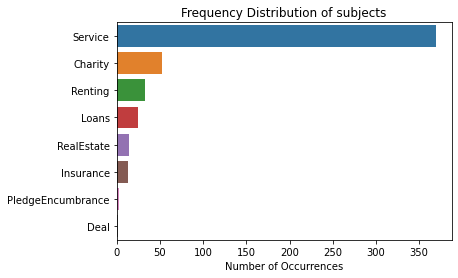

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

subj_count = trainset_rows['subject'].value_counts()
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()

### Replace subject codes with `one-hots`

In [0]:
from analyser.structures import ContractSubject
from keras.utils import to_categorical

# all_subjects = np.array( [ [s.name, s.value] for s in ContractSubject] ).T
all_subjects_map ={s.name : s.value  for s in ContractSubject}

_cats = to_categorical( list(all_subjects_map.values()) )
print(_cats.shape)

subject_name_1hot_map={}
for i, k in enumerate(all_subjects_map.keys()):
  print (k)
  subject_name_1hot_map[k] = _cats[i]

plot_emb( np.array( list(  subject_name_1hot_map.values())))
 

In [0]:
# all_subjects_map ={s.name : s.value  for s in ContractSubject}
# print(all_subjects_map)
# print(all_subjects_map.values())

In [0]:
_cats = trainset_rows['subject'].astype('category').cat.categories.tolist()
replace_map  =  { k: v for k, v in zip(_cats, list(range(1, len(_cats)+1))) }

trainset_rows_r = trainset_rows.replace({'subject':replace_map}, inplace=False)
trainset_rows_r.head()

#----
del trainset_rows_r
del replace_map

In [0]:
# import numpy as np
# from keras.utils import to_categorical

# Y = to_categorical(trainset_rows_r['subject'])
# print(Y.shape, Y[0])

### Balance trainset


In [11]:
print ('-distribution-')
for si in subj_count.index:
  print(si, subj_count[si])

print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

-distribution-
Service 369
Charity 52
Renting 33
Loans 25
RealEstate 14
Insurance 13
PledgeEncumbrance 3
Deal 1

min 1
max 369
total 510


#### Group by subjects (put row indices into bags)

1. distribute row numbers by bags
2. oversample each bag

In [12]:
#make empty bags
subject_bags = {}
for key in subj_count.index:
  subject_bags[key]=[]
print(subject_bags)


row_no:int = 0
for index, row in trainset_rows.iterrows():

  row_by_no = trainset_rows.iloc[row_no]
  subj_code = row["subject"]
  bag = subject_bags[subj_code]
  bag.append(row_no)
  # print (row_no, index, row_by_no["subject"], row["subject"], row["confidence"])
  
  row_no += 1
print('sample bag ')
subject_bags['PledgeEncumbrance']

{'Service': [], 'Charity': [], 'Renting': [], 'Loans': [], 'RealEstate': [], 'Insurance': [], 'PledgeEncumbrance': [], 'Deal': []}
sample bag 


[91, 92, 93]

2. oversample with np.tile: just repeat the indices stored in named bags. 

WARN: do not run it twice


In [13]:
_desired_number_of_samples = max (subj_count.values)
for subj_code in subject_bags:
  bag = subject_bags[subj_code]
  if len(bag)<_desired_number_of_samples:  
    repeats = int(_desired_number_of_samples / len(bag))
    bag = sorted(np.tile(bag, repeats))
    subject_bags[subj_code] = bag
  print (subj_code, len(bag))

print()
print('sample bag after oversampling:', subject_bags['PledgeEncumbrance'])


Service 369
Charity 364
Renting 363
Loans 350
RealEstate 364
Insurance 364
PledgeEncumbrance 369
Deal 369

sample bag after oversampling: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9

split all bags into train and validation sets

In [14]:
VALIDATION_SET_PROPORTION = 0.25
subject_bags_test = {}
subject_bags_train = {}

for subj_code in subject_bags:
  bag = subject_bags[subj_code]
  split_index:int = int(len(bag) * VALIDATION_SET_PROPORTION)
  print(split_index)
  
  subject_bags_test [subj_code] = bag[:split_index]
  subject_bags_train [subj_code] = bag[split_index:]

print('\n--subject_bags_train')
for subj_code in subject_bags_train:
  bag = subject_bags_train[subj_code]  
  print (subj_code, len(bag))
print('\n--subject_bags_test')
for subj_code in subject_bags_test:
  bag = subject_bags_test[subj_code]  
  print (subj_code, len(bag))

92
91
90
87
91
91
92
92

--subject_bags_train
Service 277
Charity 273
Renting 273
Loans 263
RealEstate 273
Insurance 273
PledgeEncumbrance 277
Deal 277

--subject_bags_test
Service 92
Charity 91
Renting 90
Loans 87
RealEstate 91
Insurance 91
PledgeEncumbrance 92
Deal 92


## Batch generator

In [0]:
train_indices = [] 
for _arr in subject_bags_train.values():
  train_indices+=_arr;

test_indices = [] 
for _arr in subject_bags_test.values():
  test_indices+=_arr;

#TODO: they probably intersect!!


from keras.preprocessing.sequence import pad_sequences
import pickle 
from analyser.legal_docs import LegalDocument

MAX_SEQUENCE_LENGTH = 999

batch_indices = np.random.choice(a = train_indices,  size = 32)
# batch_indices

embeddings_cache={}



def get_embeddings(filename):
  if filename in embeddings_cache:
    return embeddings_cache[filename]
  else:
    with open(filename, "rb") as pickle_in:    
      # print('reading... ', filename)
      doc:LegalDocument = pickle.load(pickle_in)
      embedding = pad_sequences([doc.embeddings], maxlen=MAX_SEQUENCE_LENGTH)[0]
      # print(doc.embeddings.shape, 'vs', embedding.shape)
      

    embeddings_cache[filename]=embedding
    return embedding

def subj_batch_generator(batch_size = 32, all_indices=train_indices):    
  while True:
    # Select files (paths/indices) for the batch
    batch_indices = np.random.choice(a = all_indices,  size = batch_size)

    batch_input  = []
    batch_output = [] 
    
    # Read in each input, perform preprocessing and get labels
    for i in batch_indices:
      _row = trainset_rows.iloc[i]
      _subj = _row['subject']
      _filename = _row['pickle']
      _emb = get_embeddings(_filename)
            
      _subject_emb = subject_name_1hot_map[_subj]

      batch_input +=  [_emb]
      batch_output +=  [_subject_emb]


    # Return a tuple of (input, output) to feed the network    
    batch_x = np.array( batch_input )
    batch_y = np.array( batch_output )

    yield (batch_x, batch_y)

test_generator = subj_batch_generator(4, all_indices = train_indices)
_t_x, _t_y =  next(test_generator)
print("sample", _t_x.shape)
print("sample", _t_y.shape)




plot_emb(_t_x[3])

### Resample trainset (deprecated)

In [0]:
# from sklearn.model_selection import train_test_split

# for i in sorted(subj_count.index):
#   print(i, subj_count[i])
# X.shape

# X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)
# y_test.shape


# Build Models

### common

In [16]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from IPython.display import SVG


from tensorflow import keras
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input
from keras.models import Sequential, Model
 
  


1.15.2


In [0]:
HISTORIES={}

def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  

def plot_compare_models():
  for key in HISTORIES:
    history=HISTORIES[key]
#     plt.plot(history.history['loss'], label=f'{key} loss')
    plt.plot(history.history['val_loss'], label=f'{key} val_loss')
  
  plt.title('Models loss')   
  plt.legend(loc='upper left')
  plt.show()

In [0]:
EPOCHS=8
BATCH_SIZE=32
EMB=1024 #;//X.shape[-1]

CLASSES=len(list(subject_name_1hot_map.values())[0])

43

In [31]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from os import mkdir

model_checkpoint_path = csv_path = path.join(TRAINSETS_PATH, 'checkpoints', VERSION_PATH)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1E-6, verbose=1)

print('model_checkpoint_path', model_checkpoint_path)
 

b_generator = subj_batch_generator(BATCH_SIZE)


model_checkpoint_path /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19


In [20]:


validation_steps = int(len(test_indices)/BATCH_SIZE)
steps_per_epoch = int(len(train_indices)/BATCH_SIZE/2)

print('validation_steps=', validation_steps)
print('steps_per_epoch=', steps_per_epoch)

def train_and_evaluate_model(model):
  checkpoint = ModelCheckpoint( path.join(model_checkpoint_path, model.name), 
                               monitor='val_loss', mode='min', save_best_only=True,
                               verbose=1) 
  history = model.fit_generator(
      generator=b_generator, 
      epochs=EPOCHS,  callbacks=[reduce_lr, checkpoint], steps_per_epoch=steps_per_epoch,
      validation_data = test_generator,
      validation_steps=validation_steps )

  HISTORIES[model.name]=history
  plot_training_history(history)
  plot_compare_models()



validation_steps= 22
steps_per_epoch= 34


## models

### baseline LSTM model

In [68]:

# define baseline model
def baseline_LSTM_model():
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes*4, return_sequences=False)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name='baseline_LSTM_model')
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model



 
model = baseline_LSTM_model(  )
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
model.name

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


Model: "baseline_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 40)                170400    
_________________________________________________________________
dense_5 (Dense)              (None, 43)                1763      
Total params: 172,163
Trainable params: 172,163
Non-trainable params: 0
_________________________________________________________________


'baseline_LSTM_model'

Epoch 1/8
34/34 [==============================] - 51s 1s/step - loss: 1.3749 - acc: 0.8097 - val_loss: 0.2015 - val_acc: 0.9659

Epoch 00001: val_loss improved from inf to 0.20151, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 2/8
34/34 [==============================] - 48s 1s/step - loss: 0.1158 - acc: 0.9945 - val_loss: 0.0624 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.20151 to 0.06237, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 3/8
34/34 [==============================] - 48s 1s/step - loss: 0.0499 - acc: 0.9972 - val_loss: 0.0264 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.06237 to 0.02636, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/baseline_LSTM_model
Epoch 4/8
34/34 [==============================] - 49s 1s/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 1.0000

Epoch 00004: val

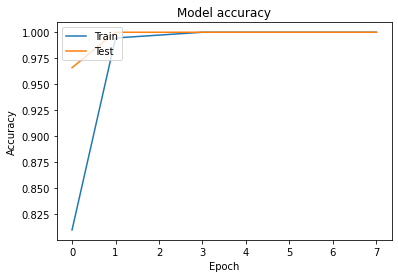

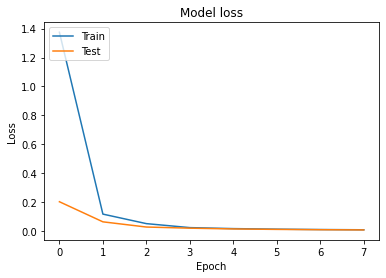

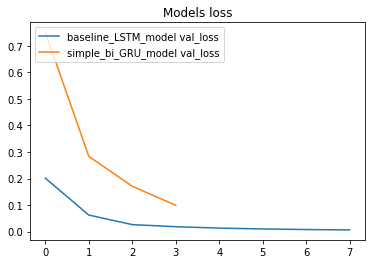

In [69]:
EPOCHS=8
train_and_evaluate_model(model)

In [22]:
# k=model.predict( X)
# subjs = list(trainset_rows['subject'])
# subjs_c = list(trainset_rows_r['subject'])

# _t_x, _t_y =  next(test_generator)

# p=model.predict(_t_x)
# for i  in range(0,200):
#   print(  subjs[i], subjs_c[i], p[i].argmax())

e=model.evaluate_generator(generator=test_generator, steps=10)
print(e)

[0.09674552977085113, 1.0]


### baseline bi-GRU  model

Model: "simple_bi_GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                125400    
_________________________________________________________________
dense_4 (Dense)              (None, 43)                1763      
Total params: 127,163
Trainable params: 127,163
Non-trainable params: 0
_________________________________________________________________


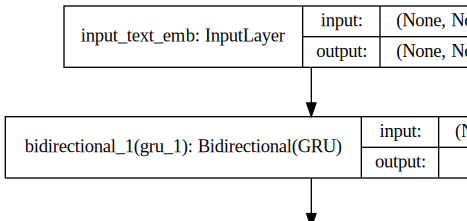

In [36]:
def simple_bi_GRU_model(name="new_model"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  Bidirectional(GRU(classes*2, return_sequences=False))(input_text)   
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  
  return model


 
model = simple_bi_GRU_model( simple_bi_GRU_model.__name__ )
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


In [0]:
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

Epoch 1/4
34/34 [==============================] - 77s 2s/step - loss: 1.8872 - acc: 0.7031 - val_loss: 0.7509 - val_acc: 0.9545

Epoch 00001: val_loss improved from inf to 0.75088, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 2/4
34/34 [==============================] - 75s 2s/step - loss: 0.5066 - acc: 0.9807 - val_loss: 0.2835 - val_acc: 0.9886

Epoch 00002: val_loss improved from 0.75088 to 0.28353, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 3/4
34/34 [==============================] - 74s 2s/step - loss: 0.2381 - acc: 0.9917 - val_loss: 0.1707 - val_acc: 0.9886

Epoch 00003: val_loss improved from 0.28353 to 0.17072, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/simple_bi_GRU_model
Epoch 4/4
34/34 [==============================] - 74s 2s/step - loss: 0.1320 - acc: 0.9991 - val_loss: 0.0992 - val_acc: 1.0000

Epoch 00004: val

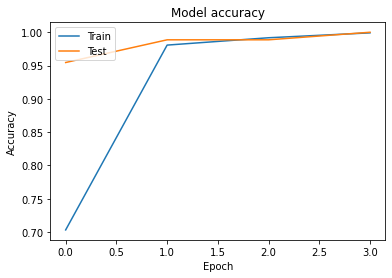

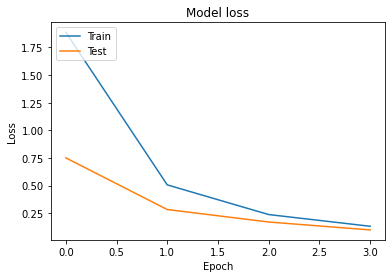

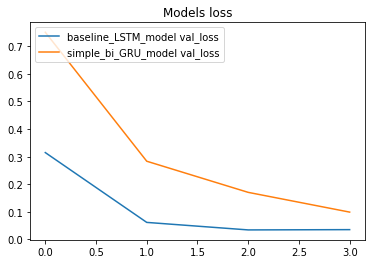

In [37]:
# checkpoint = ModelCheckpoint( path.join(model_checkpoint_path, model.name), monitor='val_loss', verbose=1, save_best_only=True, mode='min') 
# # //model.fit(  X[test_region] ,  labels[test_region] , validation_split=0.25, epochs=EPOCHS, batch_size=64,  callbacks=[reduce_lr, checkpoint] )

# # model.fit(  X_train ,  y_train , validation_split=0.25, epochs=EPOCHS*4, batch_size=32,  callbacks=[reduce_lr, checkpoint], validation_data=(X_test, y_test) )
# model.fit_generator(generator=b_generator, epochs=EPOCHS*2,  callbacks=[reduce_lr, checkpoint], steps_per_epoch=20 )

EPOCHS=4
train_and_evaluate_model(model)

In [26]:
# # k=model.predict( X)
# subjs = list(trainset_rows['subject'])
# subjs_c = list(trainset_rows_r['subject'])

# p=model.predict(X)
# for i  in range(0,len(p)):
#   max_i=p[i].argmax()
#   print(  subjs[i], subjs_c[i], max_i, f'{p[i][max_i]}')


model.evaluate_generator(generator=test_generator, steps=100)


[0.008997679337626322, 1.0]

In [27]:
model.evaluate_generator(generator=b_generator, steps=100)

[0.008753084745258093, 1.0]

'baseline_GRU_model'

# Playground

In [0]:
row_no:int=0

prediction_col_name='predicted_subj'
model_validation_meta = trainset_meta[ trainset_meta['subject']!='?' ].copy()
model_validation_meta[prediction_col_name]='?'
model_validation_meta[prediction_col_name+"_conf"]=0.0
model_validation_meta[prediction_col_name+"_valid"]=False

for index, row in model_validation_meta.iterrows():
  row_by_no = model_validation_meta.iloc[row_no]

  _subj=row_by_no['subject']
  _filename=row_by_no['pickle']   
  
  _emb = get_embeddings(_filename)  
  _onehot = subject_name_1hot_map[ _subj ]

  

  result = model.predict( np.array( []+ [_emb]) )
  max_i=result[0].argmax()
  predicted_subj_name=ContractSubject(max_i).name

  model_validation_meta[prediction_col_name][index]  = predicted_subj_name
  model_validation_meta[prediction_col_name+"_conf"][index]  = result[0][max_i]
  model_validation_meta[prediction_col_name+"_valid"][index]  = predicted_subj_name==_subj

  print(row_no, index, _subj,'-->', predicted_subj_name, row_by_no['valid'], result[0][max_i] )
  

  if row_no%5==0:
    model_validation_meta.to_csv(path.join(model_checkpoint_path, model.name)+'.csv', encoding='utf-8', index=True)
    model_validation_meta.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

  row_no+=1

  # if row_no > 21:
  #   break

model_validation_meta.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

In [0]:

model_validation_meta[model_validation_meta[prediction_col_name] != '?']